In [612]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras.models import Sequential 
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import PIL
import tensorflow as tf
import os, shutil
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from keras.layers import Dense, Dropout
from imblearn.over_sampling import SMOTE
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from keras.metrics import Accuracy, AUC, Precision, Recall
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
from keras import layers
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve, confusion matrix
import itertools
np.random.seed(123)
sns.set()

In [2]:

def len_of_dir(directory1, directory2):
    #retrieve the length of the first and second directory
    
    return len(os.listdir(directory2)) + len(os.listdir(directory1))

def create_generators(directory, batch_size):
    #create generators for image files
    generator = ImageDataGenerator(rescale = 1./255).flow_from_directory(directory,
                                                                         target_size= (64,64),
                                                                         batch_size= batch_size,
                                                                         class_mode= 'binary')
    return generator


def check_shape(images):
    #prints the shape of the images
    
    print("Dimensions of set:",images.shape)
    
def plot_imbalance(x, y, count_of_plots = 1):
    if count_of_plots == 1:
        fig, ax = plt.subplots(1,1, figsize = (10,8))
        ax.bar(x, y)
        ax.set_ylabel('Count')
        plt.title('Count of Pneumonia vs Normal Chest X-Ray')
        
       
        
    
    
def check_for_data_imbalance(data):
    imbalance = np.count_nonzero(data, axis = 0)
    
    normal = imbalance[0]
    pneumonia = imbalance[1]
    plot_imbalance(['Normal', 'Pneumonia'], [normal, pneumonia])
    
    ratio = normal / pneumonia
    return ratio


def plot_accuracy_loss(train_loss, val_loss, train_acc, val_acc, epochs):
    
    epochs = list(range(0,epochs))
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,5))
    
    ax1.plot(epochs, train_acc, label = 'Training Accuracy')
    ax1.plot(epochs,val_acc , label = 'Validation Accuracy')
    ax1.set_title('Training Accuracy vs Validation Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    
    ax2.plot(epochs, train_loss, label = 'Training Loss')
    ax2.plot(epochs, val_loss, label = 'Validation Loss')
    ax2.set_title('Training Loss vs Validation Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    plt.title('Training Loss vs Validation Loss',)
    plt.legend()
    

    

# Problem Statement

A healthcare software company has identified a key opportunity in chest x-rays. They have asked the Data Scientist to determine the likelihood of pneumonia using chest x-rays. The goal of this project is to use machine learning and deep learning techniques to classify chest x-rays into normal and peumonia cases. This is a binary classification task.

A dataset was procured from 

# Data Preparation

The files are set up in the 'chest_xray' directory. Within this directory there are 3 subdirectories containing a training, validation and test set. We will explore some models to determine a model that we can use with great confidence.

In [3]:
#assign variables to the directories and subdirectories containing the xrays

train_dir = 'chest_xray/train/'
train_dir_normal = 'chest_xray/train/NORMAL/'
train_dir_pneumonia = 'chest_xray/train/PNEUMONIA/'

test_dir = 'chest_xray/test/'
test_dir_normal = 'chest_xray/test/NORMAL/'
test_dir_pneumonia = 'chest_xray/test/PNEUMONIA/'

val_dir = 'chest_xray/val'
val_dir_normal = 'chest_xray/val/NORMAL/'
val_dir_pneumonia = 'chest_xray/val/PNEUMONIA/'

In [4]:
# find the amount of images there are for each set for preprocessing

length_of_train = len_of_dir(train_dir_normal, train_dir_pneumonia)

length_of_val = len_of_dir(val_dir_normal, val_dir_pneumonia)

length_of_test = len_of_dir(test_dir_normal, test_dir_pneumonia)


In [764]:
#generate batches of images 
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(train_dir, 
                                                                         target_size=(64, 64),
                                                                         batch_size = length_of_train)

test_generator = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_dir,
                                                                          target_size=(64,64),
                                                                          batch_size= length_of_test)
val_generator = ImageDataGenerator(rescale = 1./255).flow_from_directory(val_dir,
                                                                         target_size=(64,64),
                                                                         batch_size= length_of_val)

#create two lists, one with images and one with predictor labels

train_images, train_labels = next(train_generator)

test_images, test_labels = next(test_generator)

val_images, val_labels = next(val_generator)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


# Exploratory Data Analysis

Let's take a look at the data. We should look at the data to determine if there is an imbalance in the dataset, how we should proceed with image augmentation, and which kind of models we will build. 

In [568]:
check_shape(train_images)
check_shape(test_images)
check_shape(val_images)

Dimensions of set: (5216, 64, 64, 3)
Dimensions of set: (624, 64, 64, 3)
Dimensions of set: (16, 64, 64, 3)


In [569]:
train_labels.shape

(5216, 2)

Let's check how balanced the dataset is. Keras allows us to initialize class weights for eac class in the model.

0.3460645161290323

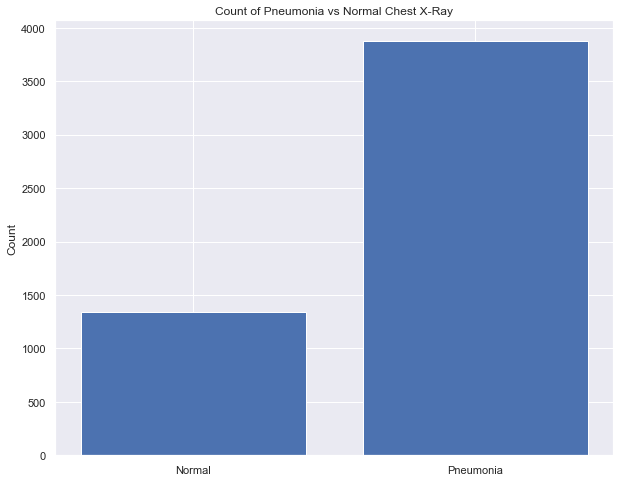

In [611]:
check_for_data_imbalance(train_labels)

In [570]:
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(val_img.shape)

(5216, 12288)
(624, 12288)
(16, 12288)


In [431]:
# we will assign the class weights for the model

initial_bias = np.log(len(os.listdir(train_dir_pneumonia))/len(os.listdir(train_dir_normal)))

initial_bias

from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced',
                                     classes= np.unique(train_aug_labels),
                                     y = train_aug_labels)

In [571]:
train_y = np.reshape(train_labels[:,0], (5216,1))
test_y = np.reshape(test_labels[:,0],(624,1))
val_y = np.reshape(val_labels[:,0],(16,1))

In [572]:
train_labels[:10]

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

Let's take a look at the actual images to see what we are working with.

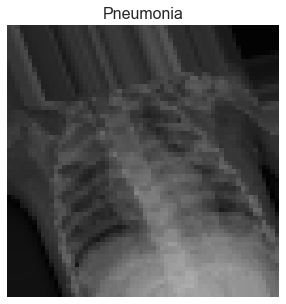

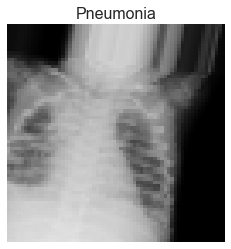

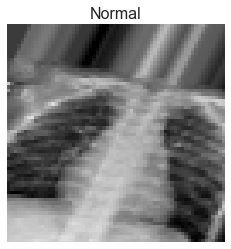

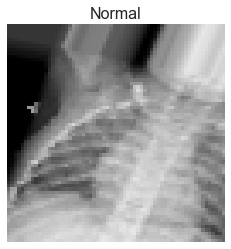

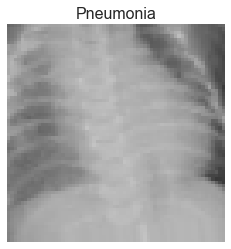

In [763]:
def plt_xrays(imgs, labels):
    plt.figure(figsize = (5,5))
    for i,img in enumerate(imgs):
        plt.imshow(img)
        plt.axis('off')
        if labels[i] == 0:
            plt.title('Normal',
                      fontdict ={'fontsize' : 16})
        else:
            plt.title('Pneumonia',
                      fontdict = {'fontsize': 16})
        plt.show()
        
    
plt_xrays(train_img[10:15], train_labels[10:15])
        
        
    

# Data Modeling

### Baseline Model

We will begin by creating a baseline model in which we will improve upon. The baseline model will be a densely connected neural network with two hidden layers and one output layer. Let's use a grid search to determine the best model with specific neurons, and epochs.

In [603]:

def create_model(optimizer = 'adam',
                 neurons = 1, 
                 second_neurons = 1, 
                 third_neurons = 1,
                 dropout = True,
                 shape = 12288):
    
    model = Sequential()
    model.add(Dense(neurons, activation = 'relu', input_shape = (shape,)))
    if dropout == True:
        model.add(Dropout(0.2))
    model.add(Dense(second_neurons, activation = 'relu'))
    if dropout == True:
        model.add(Dropout(0.2))
    model.add(Dense(third_neurons, activation = 'relu'))
    model.add(Dense(1, activation = 'sigmoid'))

# Compile model
    model.compile(optimizer = optimizer,
                  loss = 'binary_crossentropy',
                  metrics = ['accuracy'],
    
             )
    
    return model

ns = 10,15,20,30,40
model = KerasClassifier(create_model,epochs = 30)
param_grids = { 'epochs': [30], 'neurons' : ns, 'second_neurons' : ns , 'third_neurons': ns}
grid = GridSearchCV(model,param_grid= param_grids, n_jobs = -1, cv = 3, verbose = 1)

grid.fit(train_img, train_y)




Fitting 3 folds for each of 125 candidates, totalling 375 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 35.1min
C:\Users\Public\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 375 out of 375 | elapsed: 76.6min finished


Epoch 1/30
163/163 [==============================] - 2s 10ms/step - loss: 0.4529 - accuracy: 0.7768
Epoch 2/30
163/163 [==============================] - 1s 7ms/step - loss: 0.3217 - accuracy: 0.8748
Epoch 3/30
163/163 [==============================] - 1s 6ms/step - loss: 0.2774 - accuracy: 0.9016
Epoch 4/30
163/163 [==============================] - 1s 7ms/step - loss: 0.2642 - accuracy: 0.9030
Epoch 5/30
163/163 [==============================] - 1s 6ms/step - loss: 0.2481 - accuracy: 0.9089
Epoch 6/30
163/163 [==============================] - 1s 7ms/step - loss: 0.2651 - accuracy: 0.8890
Epoch 7/30
163/163 [==============================] - 1s 8ms/step - loss: 0.3567 - accuracy: 0.7928
Epoch 8/30
163/163 [==============================] - 1s 7ms/step - loss: 0.3348 - accuracy: 0.8067
Epoch 9/30
163/163 [==============================] - 1s 7ms/step - loss: 0.3392 - accuracy: 0.8050
Epoch 10/30
163/163 [==============================] - 1s 7ms/step - loss: 0.3278 - accuracy: 0.814

GridSearchCV(cv=3,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x000002063C030C88>,
             n_jobs=-1,
             param_grid={'epochs': [30], 'neurons': (10, 15, 20, 30, 40),
                         'second_neurons': (10, 15, 20, 30, 40),
                         'third_neurons': (10, 15, 20, 30, 40)},
             verbose=1)

In [604]:
grid.best_params_

{'epochs': 30, 'neurons': 30, 'second_neurons': 20, 'third_neurons': 15}

In [607]:
baseline_model = create_model(optimizer = 'adam',
                              neurons= 30,
                              second_neurons= 20,
                              third_neurons= 5,
                              dropout = True,
                              shape=12288)

es = EarlyStopping(monitor='loss', mode = 'min', patience= 10, restore_best_weights = True)
baseline_model_history = baseline_model.fit(train_img,
                                            train_y,
                                            epochs = 50,
                                            callbacks = [es],
                                            batch_size = 32,
                                            validation_data = (val_img, val_y))

Epoch 1/50
163/163 [==============================] - 3s 21ms/step - loss: 0.5085 - accuracy: 0.7540 - val_loss: 0.8356 - val_accuracy: 0.5625
Epoch 2/50
163/163 [==============================] - 2s 10ms/step - loss: 0.3514 - accuracy: 0.8426 - val_loss: 1.1858 - val_accuracy: 0.5625
Epoch 3/50
163/163 [==============================] - 2s 9ms/step - loss: 0.2780 - accuracy: 0.9005 - val_loss: 0.4240 - val_accuracy: 0.8750
Epoch 4/50
163/163 [==============================] - 3s 17ms/step - loss: 0.3229 - accuracy: 0.8405 - val_loss: 0.4022 - val_accuracy: 0.9375
Epoch 5/50
163/163 [==============================] - 2s 10ms/step - loss: 0.3635 - accuracy: 0.7901 - val_loss: 0.4248 - val_accuracy: 0.9375
Epoch 6/50
163/163 [==============================] - 1s 8ms/step - loss: 0.3281 - accuracy: 0.8242 - val_loss: 0.4817 - val_accuracy: 0.8750
Epoch 7/50
163/163 [==============================] - 1s 6ms/step - loss: 0.3183 - accuracy: 0.8524 - val_loss: 0.4574 - val_accuracy: 0.8750
Ep

In [609]:
baseline_model.evaluate(test_img, test_y)

20/20 [==============================] - 0s 8ms/step - loss: 0.6166 - accuracy: 0.7756


[0.6166448593139648, 0.7756410241127014]

The baseline model had an overall accuracy of 76% on the test case. Let's try to scale the data using the StandardScaler and use principal component analysis to reduce the dimensions of the dataset. We will try and capture 99% of the data with PCA. We will also include dropout set at 0.2 for each layer in the model.

In [598]:
scaler = StandardScaler()
scaled_train_img = scaler.fit_transform(train_img)
scaled_val_img = scaler.transform(val_img)

pca = PCA(0.99)
pca_transformed = pca.fit_transform(scaled_train_img)
pca_val = pca.transform(scaled_val_img)

In [599]:
scaled_test = scaler.transform(test_img)

pca_test = pca.transform(scaled_test)

In [162]:
pca_val.shape

(16, 1806)

In [600]:
baseline = create_model(optimizer = 'adam', neurons = 30, 
                        second_neurons=20, third_neurons= 1,
                        dropout = True, shape = 1806)

baseline_history = baseline.fit(pca_transformed, 
                                train_y, 
                                epochs = 50,
                                class_weight = {0:class_weights[0],
                                                1:class_weights[1] },
                                batch_size = 32, 
                                callbacks = [es],
                                validation_data = (pca_val, val_y))

Epoch 1/50
163/163 [==============================] - 1s 5ms/step - loss: 0.4856 - accuracy: 0.7809 - val_loss: 1.0342 - val_accuracy: 0.5625
Epoch 2/50
163/163 [==============================] - 0s 2ms/step - loss: 0.1779 - accuracy: 0.9141 - val_loss: 0.9073 - val_accuracy: 0.5625
Epoch 3/50
163/163 [==============================] - 0s 2ms/step - loss: 0.1101 - accuracy: 0.9521 - val_loss: 1.0466 - val_accuracy: 0.6250
Epoch 4/50
163/163 [==============================] - 0s 2ms/step - loss: 0.0673 - accuracy: 0.9688 - val_loss: 0.8649 - val_accuracy: 0.6875
Epoch 5/50
163/163 [==============================] - 0s 2ms/step - loss: 0.0396 - accuracy: 0.9845 - val_loss: 0.8948 - val_accuracy: 0.7500
Epoch 6/50
163/163 [==============================] - 0s 2ms/step - loss: 0.0270 - accuracy: 0.9893 - val_loss: 1.0753 - val_accuracy: 0.6875
Epoch 7/50
163/163 [==============================] - 0s 3ms/step - loss: 0.0203 - accuracy: 0.9931 - val_loss: 1.4597 - val_accuracy: 0.6875
Epoch 

In [601]:
baseline.evaluate(pca_test, test_y)

20/20 [==============================] - 0s 4ms/step - loss: 3.0158 - accuracy: 0.7404


[3.0158097743988037, 0.7403846383094788]

Not much of an improvement. 

# Build a CNN Model

Now let's build a CNN. For image recognition, convolutional neural networks work much better than densely connected layers. Running a gridsearch on a CNN can take a very long time. So it is important to be wise in selecting the amount of neurons and how many layers you have on the model. 

In [447]:
from keras.callbacks import EarlyStopping

def create_cnn_model(first = 16, 
                     second = 32,
                     third = 64, 
                     dropout = True, 
                     optimizer = "sgd",
                     ):
    
    model = Sequential()
    model.add(layers.Conv2D(first, (3,3), activation = 'relu', input_shape = (64,64,3)))
    model.add(layers.MaxPooling2D((2,2)))
        
    model.add(layers.Conv2D(second, (3,3), activation = 'relu'))
    model.add(layers.MaxPooling2D((2,2)))
    
    model.add(layers.Conv2D(third, (3,3), activation = 'relu'))
    model.add(layers.MaxPooling2D((2,2)))
   
    
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation = 'relu')) 
    if dropout == True:
        model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1, activation = 'sigmoid'))
        
    model.compile(loss = 'binary_crossentropy',
                  optimizer = optimizer,
                  metrics = ['acc'])
    
    return model


In [20]:
model = create_cnn_model()
es = EarlyStopping(monitor='loss', mode = 'min', patience= 4, restore_best_weights = True)
history = model.fit(train_images,
                    train_y,
                    epochs = 100,
                    batch_size = 32,
                    callbacks = [es],
                    validation_data = (val_images, val_y))

Epoch 1/100
163/163 [==============================] - 24s 149ms/step - loss: 0.5736 - acc: 0.7360 - val_loss: 0.7504 - val_acc: 0.5000
Epoch 2/100
163/163 [==============================] - 24s 145ms/step - loss: 0.5177 - acc: 0.7529 - val_loss: 0.7871 - val_acc: 0.5000
Epoch 3/100
163/163 [==============================] - 25s 151ms/step - loss: 0.4289 - acc: 0.8023 - val_loss: 0.8107 - val_acc: 0.5625
Epoch 4/100
163/163 [==============================] - 25s 151ms/step - loss: 0.3289 - acc: 0.8597 - val_loss: 0.8818 - val_acc: 0.6250
Epoch 5/100
163/163 [==============================] - 27s 168ms/step - loss: 0.2562 - acc: 0.8892 - val_loss: 0.5510 - val_acc: 0.5625
Epoch 6/100
163/163 [==============================] - 28s 169ms/step - loss: 0.2224 - acc: 0.9105 - val_loss: 0.4612 - val_acc: 0.7500
Epoch 7/100
163/163 [==============================] - 26s 157ms/step - loss: 0.1938 - acc: 0.9231 - val_loss: 0.3582 - val_acc: 0.8750
Epoch 8/100
163/163 [===========================

In [22]:
model.evaluate(test_images, test_y)

20/20 [==============================] - 1s 31ms/step - loss: 0.5212 - acc: 0.7837


[0.5212469696998596, 0.7836538553237915]

Just a bit better than our previous model. The CNN model is 78% accurate on identifying the test case. This is a great improvement on the previous model which only had about a 79% accuracy. Early stopping was used to to prevent overfitting to the training set. 

In [23]:
model_2 = create_cnn_model(optimizer = 'adam')
es = EarlyStopping(monitor='acc', mode = 'max', patience= 4, restore_best_weights = True)
history = model_2.fit(train_generator,
                    epochs = 100,
                    batch_size = 32,
                    callbacks = [es],
                    validation_data = val_generator,
                    validation_steps = 1)

Epoch 1/100
163/163 [==============================] - 125s 764ms/step - loss: 0.4901 - acc: 0.7780 - val_loss: 0.6028 - val_acc: 0.6875
Epoch 2/100
163/163 [==============================] - 124s 762ms/step - loss: 0.3026 - acc: 0.8664 - val_loss: 0.6420 - val_acc: 0.7500
Epoch 3/100
163/163 [==============================] - 146s 898ms/step - loss: 0.2644 - acc: 0.8792 - val_loss: 0.6014 - val_acc: 0.6875
Epoch 4/100
163/163 [==============================] - 127s 782ms/step - loss: 0.2348 - acc: 0.9001 - val_loss: 1.0037 - val_acc: 0.5625
Epoch 5/100
163/163 [==============================] - 111s 683ms/step - loss: 0.2285 - acc: 0.9016 - val_loss: 0.7684 - val_acc: 0.6250
Epoch 6/100
163/163 [==============================] - 102s 623ms/step - loss: 0.2095 - acc: 0.9145 - val_loss: 0.5464 - val_acc: 0.7500
Epoch 7/100
163/163 [==============================] - 104s 638ms/step - loss: 0.2012 - acc: 0.9181 - val_loss: 0.4597 - val_acc: 0.6875
Epoch 8/100
163/163 [====================

In [21]:
model_2.evaluate(test_generator)

1/1 [==============================] - 0s 995us/step - loss: 0.5408 - acc: 0.8365


[0.540833592414856, 0.8365384340286255]

In [25]:
model_3 = create_cnn_model(optimizer = 'rmsprop')

model_3.fit(train_generator,
            epochs = 100,
            batch_size = 32,
            callbacks = [es],
            validation_data = val_generator,
            validation_steps = 1)

Epoch 1/100
163/163 [==============================] - 119s 728ms/step - loss: 0.5418 - acc: 0.7456 - val_loss: 0.6011 - val_acc: 0.5000
Epoch 2/100
163/163 [==============================] - 123s 754ms/step - loss: 0.4109 - acc: 0.8073 - val_loss: 1.1414 - val_acc: 0.5000
Epoch 3/100
163/163 [==============================] - 105s 645ms/step - loss: 0.3252 - acc: 0.8579 - val_loss: 0.5435 - val_acc: 0.7500
Epoch 4/100
163/163 [==============================] - 105s 642ms/step - loss: 0.2868 - acc: 0.8758 - val_loss: 0.6740 - val_acc: 0.6250
Epoch 5/100
163/163 [==============================] - 104s 635ms/step - loss: 0.2431 - acc: 0.8992 - val_loss: 0.3149 - val_acc: 0.8125
Epoch 6/100
163/163 [==============================] - 103s 635ms/step - loss: 0.2192 - acc: 0.9066 - val_loss: 0.2666 - val_acc: 0.8750
Epoch 7/100
163/163 [==============================] - 104s 639ms/step - loss: 0.2087 - acc: 0.9160 - val_loss: 0.4085 - val_acc: 0.7500
Epoch 8/100
163/163 [====================

In [33]:
model_3.evaluate(test_generator)

1/1 [==============================] - 0s 998us/step - loss: 0.3630 - acc: 0.8910


[0.36295637488365173, 0.8910256624221802]

In [16]:
model_4 = create_cnn_model(optimizer= 'adam')
es = EarlyStopping(monitor='loss', mode = 'min', patience= 4, restore_best_weights = True)
history = model_4.fit(train_generator,
                    epochs = 100,
                    batch_size = 32,
                    validation_data = val_generator,
                    callbacks = [es],
                    validation_steps = 1)

classification_report()

Epoch 1/100
163/163 [==============================] - 165s 1s/step - loss: 0.5081 - acc: 0.7617 - val_loss: 0.6090 - val_acc: 0.6250
Epoch 2/100
163/163 [==============================] - 140s 861ms/step - loss: 0.3450 - acc: 0.8495 - val_loss: 0.6652 - val_acc: 0.6250
Epoch 3/100
163/163 [==============================] - 79s 485ms/step - loss: 0.2899 - acc: 0.8717 - val_loss: 0.4798 - val_acc: 0.8125
Epoch 4/100
163/163 [==============================] - 79s 486ms/step - loss: 0.2609 - acc: 0.8892 - val_loss: 0.6305 - val_acc: 0.6875
Epoch 5/100
163/163 [==============================] - 79s 487ms/step - loss: 0.2437 - acc: 0.8965 - val_loss: 0.6673 - val_acc: 0.6875
Epoch 6/100
163/163 [==============================] - 80s 489ms/step - loss: 0.2205 - acc: 0.9093 - val_loss: 0.4020 - val_acc: 0.8125
Epoch 7/100
163/163 [==============================] - 80s 490ms/step - loss: 0.1988 - acc: 0.9176 - val_loss: 0.6614 - val_acc: 0.7500
Epoch 8/100
163/163 [============================

In [17]:
model_4.evaluate(test_generator)

1/1 [==============================] - 0s 4ms/step - loss: 0.4734 - acc: 0.8702


[0.4734281897544861, 0.870192289352417]

# Data Augmentation

Images can be augmentated to help a model generalize the training data. You can augment the image in many different ways such as rotation, width shift, height shift, shear, and zoom. 

In [627]:
train_data_gen = ImageDataGenerator(rescale = 1./255,
                                    rotation_range= 20,
                                    width_shift_range= 0.2,
                                    height_shift_range= 0.2,
                                    shear_range= 0.3,
                                    zoom_range= 0.3,
                                    )

test_generator = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_dir,
                                                                          target_size = (64,64),
                                                                          batch_size = 624,
                                                                          class_mode = 'binary')

val_generator = ImageDataGenerator(rescale= 1./255).flow_from_directory(val_dir,
                                                                       target_size = (64,64),
                                                                       batch_size = 16,
                                                                       class_mode = 'binary')
train_generator = train_data_gen.flow_from_directory(train_dir,
                                                     target_size = (64,64),
                                                     batch_size = 5216,
                                                     class_mode = 'binary')
                                   

Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 5216 images belonging to 2 classes.


In [628]:
train_img, train_labels = next(train_generator)
val_img, val_labels = next(val_generator)
test_img, test_labels = next(test_generator)

In [643]:
model_4 = Sequential()
model_4.add(layers.Conv2D(16, (3, 3), activation='relu',
                        input_shape=(64 ,64,  3)))
model_4.add(layers.MaxPooling2D((2, 2)))

model_4.add(layers.Conv2D(32, (4, 4), activation='relu'))
model_4.add(layers.MaxPooling2D((2, 2)))

model_4.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_4.add(layers.MaxPooling2D((2, 2)))

model_4.add(layers.Flatten())
model_4.add(layers.Dense(128, activation='relu'))
model_4.add(layers.Dropout(0.2))
model_4.add(layers.Dense(1, activation='sigmoid'))

model_4.compile(loss='binary_crossentropy',
              optimizer= 'adam',
              metrics=['acc'],
            )

In [644]:
es = EarlyStopping(monitor='val_loss', mode = 'min', patience= 10, restore_best_weights = False)
history_4 = model_4.fit(train_img, train_labels, 
                        epochs=30, 
                        validation_data=(val_img,val_labels),
                        class_weight={0:class_weights[0], 1:class_weights[1]},
                        
                        callbacks = [es])

Epoch 1/30
163/163 [==============================] - 22s 136ms/step - loss: 0.6207 - acc: 0.5815 - val_loss: 0.5343 - val_acc: 0.7500
Epoch 2/30
163/163 [==============================] - 19s 116ms/step - loss: 0.4237 - acc: 0.8094 - val_loss: 0.4430 - val_acc: 0.8125
Epoch 3/30
163/163 [==============================] - 19s 116ms/step - loss: 0.3234 - acc: 0.8512 - val_loss: 0.3694 - val_acc: 0.8125
Epoch 4/30
163/163 [==============================] - 19s 115ms/step - loss: 0.3078 - acc: 0.8583 - val_loss: 0.3426 - val_acc: 0.8125
Epoch 5/30
163/163 [==============================] - 19s 117ms/step - loss: 0.2573 - acc: 0.8882 - val_loss: 0.4147 - val_acc: 0.8125
Epoch 6/30
163/163 [==============================] - 19s 119ms/step - loss: 0.2352 - acc: 0.8955 - val_loss: 0.1810 - val_acc: 0.9375
Epoch 7/30
163/163 [==============================] - 20s 121ms/step - loss: 0.2106 - acc: 0.9076 - val_loss: 0.2555 - val_acc: 0.8750
Epoch 8/30
163/163 [==============================] - 2

In [646]:
model_4.evaluate(test_img, test_labels)

20/20 [==============================] - 2s 104ms/step - loss: 0.4896 - acc: 0.9231


[0.48962265253067017, 0.9230769276618958]

In [354]:
#nitialize empty arrays 
train_aug_imgs = np.zeros([5216,64,64,3])
train_aug_labels = np.zeros([5216])

#create 8 sets of augmented training data
for i in list(range(0,8)):
    train_data_gen = ImageDataGenerator(rescale = 1./255,
                                    rotation_range= 20,
                                    width_shift_range= 0.2,
                                    height_shift_range= 0.2,
                                    shear_range= 0.3,
                                    zoom_range= 0.3,
                                    )
    train_generator = train_data_gen.flow_from_directory(train_dir,
                                                     target_size = (64,64),
                                                     batch_size = 5216,
                                                     class_mode = 'binary',
                                                     save_to_dir = './chest_xray/data_generated/'
                                                 )
    
    train_img, train_labels = next(train_generator)
    if i == 0:
        train_aug_labels = np.concatenate((train_aug_labels, train_labels))
        train_aug_labels = np.delete(train_aug_labels, range(0,5216), axis = 0)
        
        train_aug_imgs = np.concatenate((train_aug_imgs, train_img))
        train_aug_imgs = np.delete(train_aug_imgs, range(0,5216), axis = 0)
        
    else:
        train_aug_imgs = np.concatenate((train_aug_imgs, train_img))
        train_aug_labels = np.concatenate((train_aug_labels, train_labels))
    
    
    
    

Found 5216 images belonging to 2 classes.
Found 5216 images belonging to 2 classes.
Found 5216 images belonging to 2 classes.
Found 5216 images belonging to 2 classes.
Found 5216 images belonging to 2 classes.
Found 5216 images belonging to 2 classes.
Found 5216 images belonging to 2 classes.
Found 5216 images belonging to 2 classes.


In [548]:
train_img_3, train_labels_3 = next(train_generator_2)
val_img_3, val_labels_3 = next(val_generator_2)
test_img_3, test_labels_3 = next(test_generator_2)

In [198]:
train_generator_2 = train_data_gen.flow_from_directory(train_dir,
                                                     target_size = (64,64),
                                                     batch_size = 5216,
                                                     class_mode = 'binary',
                                                     save_to_dir = './chest_xray/data_generated/'
                                                 )
train_img2, train_labels2 = next(train_generator_2)

Found 5216 images belonging to 2 classes.


In [200]:
train_labels_2 = np.concatenate((train_labels, train_labels2))
train_img_2 = np.concatenate((train_img, train_img2))

A 94% accuracy at classifying the images. A great improvement from our baseline model and previous CNN model. The more important score, the recall score of the pneumonia cases at 98% shows a near perfect score.

In [557]:
test_predict = model_4.predict_classes(test_img)

report = classification_report(test_labels, test_predict)

print(report)

              precision    recall  f1-score   support

         0.0       0.97      0.87      0.91       234
         1.0       0.93      0.98      0.95       390

    accuracy                           0.94       624
   macro avg       0.95      0.92      0.93       624
weighted avg       0.94      0.94      0.94       624



Confusion matrix, without normalization
[[201  33]
 [ 15 375]]


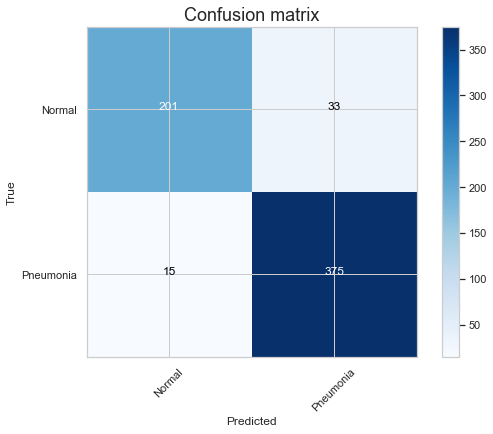

In [736]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontdict={'fontsize': 18})
    sns.set_style( 'whitegrid',{'axes.grid' : False})
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")
    plt.ylim([1.5,-.5])
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.grid('off')
    plt.show()
plt.figure(figsize = (8,6))
plot_confusion_matrix(cm, classes = ['Normal', 'Pneumonia'])


Normalized confusion matrix
[[0.85897436 0.14102564]
 [0.03846154 0.96153846]]


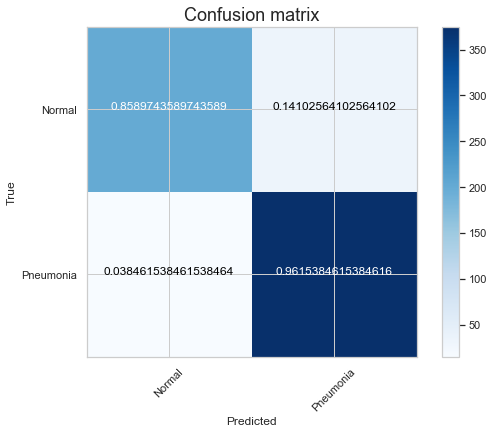

In [737]:
plt.figure(figsize = (8,6))
plot_confusion_matrix(cm, normalize = True,classes= ['Normal', 'Pneumonia'])

# Conclusion

With the image dataset of around 6,000 images, the baseline model gave an accuracy of approximately 75%. Improvements were made to the model by way of using class weights for each class; using a cnn model instead of a multilayer perceptron; implementing image augmentation with varying parameters.

The final model produced an accuracy of approximately 93%. Now the false positive and false negative rates are also rates we need to take into consideration. We were able to accurately predict the cases of pneumonia with a 98% recall score and a predicted cases of not having pneumonia at 87%. Ultimately, in this domain, we are in the business of saving lives. So this recall score is just we we want to not miss any patients with pneumonia.

Convolutional neural networks work best for image recognition, hence the high accuracy for this dataset.

# Recommendations

1. This dataset is specifically from a Guangzho with female patients aged 1-5. We should gather more data to generalize across all ages and both sexes. 

2. Use this deep learning model under a simple GUI for healthcare professionals to use.

3. Update the training set constantly to generalize the model with images coming from the healthcare professionals we partner with.

